# Fake new detection task project

In [ ]:
import pandas as pd
import numpy as np
import copy
import random

random.seed(27)

## Load dataset

Training set given for the challenge

In [ ]:
trainingset = pd.read_csv('Task3a_training.csv')
trainingset.head(7)

public_id  ...       our rating
0  5a228e0e  ...            FALSE
1  30c605a1  ...  partially false
2  c3dea290  ...  partially false
3  f14e8eb6  ...            FALSE
4  faf024d6  ...            FALSE
5  c03ed5db  ...            other
6  61bd9a69  ...            FALSE

[7 rows x 4 columns]

Test set given for the challenge

In [ ]:
testset = pd.read_csv('Task3a_testing.csv')
testset.head(7)

public_id  ...       our rating
0  81a67c96  ...  partially false
1  6e5ec6fb  ...            false
2  d9cd4895  ...            false
3  4a1a9b9f  ...            false
4  6d16fa40  ...            false
5  31d75b45  ...            false
6  073f3552  ...            other

[7 rows x 4 columns]

Some example data (50 examples) given for the challenge at the beginning to understand the type of dataset. This is different from the train and test data so I decide to add theme to the training set.

In [ ]:
sample = pd.read_csv('task_3a_sample_data.csv',sep='\t')
sample.head(7)

public_id  ...       our rating
0  f2182a54  ...            FALSE
1  c5175d8d  ...             TRUE
2  392886ea  ...            FALSE
3  bc6d5d55  ...  partially false
4  b8437efb  ...            FALSE
5  faf024d6  ...            FALSE
6  0f086930  ...            FALSE

[7 rows x 4 columns]

In [ ]:
# Transform uppercase target to lowercase
for i,r in enumerate(sample['our rating']):
  sample['our rating'][i] = r.lower()
sample.head()

public_id  ...       our rating
0  f2182a54  ...            false
1  c5175d8d  ...             true
2  392886ea  ...            false
3  bc6d5d55  ...  partially false
4  b8437efb  ...            false

[5 rows x 4 columns]

In [ ]:
# Make label in lower case
for i,r in enumerate(trainingset['our rating']):
  trainingset['our rating'][i] = r.lower()

# Shuffle the training set
trainingset = trainingset.sample(frac=1)
trainingset.head(7)

public_id  ...       our rating
803  78252d69  ...  partially false
557  f07e2cf1  ...             true
424  74604cc9  ...            other
9    f2182a54  ...            false
126  013da3e3  ...            other
413  62a86a8c  ...  partially false
423  289d959a  ...  partially false

[7 rows x 4 columns]

External data: load a training set of about 5000 examples to add to the current training set.

Data find on kaggle for a challenge on fake news detection. The data contain the text of the articles and the label assigned to them: only true or false for this dataset.

In [ ]:
othertrain = pd.read_csv('train.csv',sep='\t')
print(othertrain.shape)
othertrain.head()

(4987, 2)


text label
0  Get the latest from TODAY Sign up for our news...     1
1  2d  Conan On The Funeral Trump Will Be Invited...     1
2  It’s safe to say that Instagram Stories has fa...     0
3  Much like a certain Amazon goddess with a lass...     0
4  At a time when the perfect outfit is just one ...     0

In [ ]:
# Use regexp to remove special characters
othertrain = othertrain.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
# Shuffle data
othertrain = othertrain.sample(frac=1)
# Extract texts
other_text = othertrain['text']
# Extract labels
other_label = othertrain['label']
# Renaming labels
for i,l in enumerate(other_label):
  if l == '0' or 0:
    other_label[i] = 'false'
  elif l == '1' or 1:
    other_label[i] = 'true'
print(other_label)

4863     true
2378     true
604      true
4024    false
2549     true
        ...  
351      true
1720    false
1987     true
4131    false
906      true
Name: label, Length: 4987, dtype: object


In [ ]:
# concatenate data except for external data
dataset = pd.concat([sample,trainingset,testset],ignore_index=True)

In [ ]:
trainDim = dataset.shape[0] - testset.shape[0]
print(trainDim)

950


In [ ]:
print("Trainingset:",trainingset.shape)
print("Testset:",testset.shape)

Trainingset: (900, 4)
Testset: (364, 4)


Possible classification:
* False
* Partially False
* True
* Other 



In [ ]:
# Count the distribution of classes of training set
freq_train = trainingset['our rating'].value_counts()
print(freq_train)
freq_train = freq_train.tolist()

false              465
partially false    217
true               142
other               76
Name: our rating, dtype: int64


In [ ]:
# Count the distribution of classes of test set
freq_test = testset['our rating'].value_counts()
print(freq_test)
freq_test = freq_test.tolist()

partially false    141
false              113
true                69
other               41
Name: our rating, dtype: int64


In [ ]:
# Count the distribution of classes of the external dataset
freq_train_other = othertrain['label'].value_counts()
print(freq_train_other)
freq_train_other = freq_train_other.tolist()

true     3514
false    1473
Name: label, dtype: int64


## Plot data

In [ ]:
import matplotlib.pyplot as plt

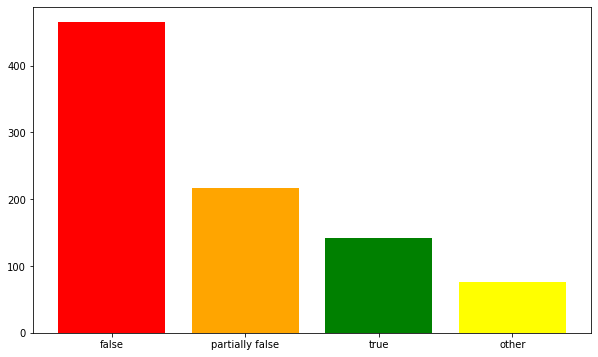

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(['false','partially false','true','other'],freq_train, color=['red','orange','green','yellow'])
plt.show()

## Preprocessing

In [ ]:
# Remove special characters and numbers
dataset = dataset.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
dataset.head()

public_id  ...       our rating
0  f2182a54  ...            false
1  c5175d8d  ...             true
2  392886ea  ...            false
3  bc6d5d55  ...  partially false
4  b8437efb  ...            false

[5 rows x 4 columns]

In [ ]:
# Getting articles
articles = dataset['text'].values
print(articles.shape)

(1314,)


In [ ]:
# Getting ratings
targets = dataset['our rating'].values
print(targets.shape)

(1314,)


In [ ]:
# adding external dataset example
articles = np.concatenate((other_text,articles))
print(articles.shape)
targets = np.concatenate((other_label,targets))
print(targets.shape)

(6301,)
(6301,)


In [ ]:
trainDim = articles.shape[0] - testset.shape[0]

In [ ]:
# Getting titles
# titles = dataset['title'].values
# print(titles.shape)
# Summing articles and titles
# titled_articles = articles.copy()
# for i in range(titles.shape[0]):
#   if type(titles[i]) == 'str': #is str:
#     titled_articles[i] += titles[i]
# print(titled_articles.shape)

Transform string to lowercase

In [ ]:
for i, t in enumerate(articles):
  articles[i] = t.lower()
print(articles.shape)

(6301,)


Remove numbers

In [ ]:
import re

# create a list of the document's text
text = []
for i in range(articles.shape[0]):
  text.append(re.sub(r'\d+', '', articles[i]))
  #text.append(articles[i]) # try with numbers 

In [ ]:
# for i,t in enumerate(articles):
#   articles[i] = ''.join(w for w in articles[i] if not w.isdigit())

Remove punctuation (done before with regexp)

In [ ]:
import string
# for i in range(articles.shape[0]):
#   text[i] = text[i].translate(str.maketrans("","", string.punctuation))

In [ ]:
# for i,t in enumerate(articles):
#   articles[i] = ''.join(w for w in articles[i] if w not in string.punctuation)

Remove stopwards

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))

text_tokenized = [] 
for i in range(articles.shape[0]):
  text_tokenized.append(word_tokenize(text[i]))

for i in range(articles.shape[0]):
  text_tokenized[i] = [j for j in text_tokenized[i] if not j in stop_words]

for j in range(articles.shape[0]):
  doc = ''
  for i in text_tokenized[j]:
    doc += ' ' + i
  text[j] = doc

In [ ]:
# stopword = stopwords.words('english')
# for i,t in enumerate(articles):
#   word_tokens = nltk.word_tokenize(articles[i])
#   articles[i] = [word for word in word_tokens if word not in stopword]

**Stemming**

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [ ]:
text_tokenized = [] 
for i in range(articles.shape[0]):
  text_tokenized.append(word_tokenize(text[i]))


for i in range(articles.shape[0]):
  stem_text = []
  for word in text_tokenized[i]:
    stem_text.append(ps.stem(word))
  text_tokenized[i] = stem_text 


for j in range(articles.shape[0]):
  doc = ''
  for i in text_tokenized[j]:
    doc += ' ' + i
  text[j] = doc

print(text[0])

 wake jennif aniston justin theroux shock separ fan one question friend actress get back togeth brad pitt hour aniston theroux announc decis part way twitter flood specul next romant move fan quick point yearold actress pitt singl first time year mani share hope ex would find way back one anoth somewher jennif aniston craft hey let grab coffe catch text brad pitt tweeter madelin hill wrote number fan excit prospect aniston pitt reignit old flame fan griev end seeminglyperfect marriag theroux other felt simpli time let linger anistonpitt nostalgia go pleas subject us stori jennif aniston get back togeth brad pitt everyon deserv break deal end marriag twitter user kristyn burtt wrote rumor swirl jennif aniston brad pitt potenti rekindl romanc twitter user flat oppos thought reunion note aniston done well sinc leav pitt past alli actor howev battl demon yall realli think jennif aniston go snif around brad pitt got kid alcohol addict meanwhil yoga bodi smart water deal w kid sight good twi

In [ ]:
# for i in range(articles.shape[0]):
#   stem_text = []
#   for word in articles[i]:
#     stem_text.append(ps.stem(word))
#   articles[i] = stem_text

# print(articles[0])

**Lemmatization**

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
# text_tokenized = [] 
# for i in range(articles.shape[0]):
#   text_tokenized.append(word_tokenize(text[i]))


# for i in range(articles.shape[0]):
#   lem_text = []
#   for word in text_tokenized[i]:
#     lem_text.append(lemmatizer.lemmatize(word))
#   text_tokenized[i] = lem_text 


# for j in range(articles.shape[0]):
#   doc = ''
#   for i in text_tokenized[j]:
#     doc += ' ' + i
#   text[j] = doc

# print(text[0])

In [ ]:
# for i in range(articles.shape[0]):
#   lem_text = []
#   for word in articles[i]:
#     lem_text.append(lemmatizer.lemmatize(word))
#   articles[i] = lem_text

# print(articles[0])

In [ ]:
print(articles.shape[0])
print(len(text))

6301
6301


### Encoding

In [ ]:
#!pip install glove-python-binary

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#import gensim
#from gensim.models import word2vec, KeyedVectors
#from gensim.scripts.glove2word2vec import glove2word2vec
#from glove import Corpus, Glove
from sklearn.preprocessing import LabelEncoder

**BAG OF WORDS**

In [ ]:
# vectorizer = CountVectorizer(binary=True)
# vectorizer_feature_t = vectorizer.fit_transform(text)
# print(vectorizer_feature_t.shape)

**N GRAMS**

In [ ]:
vectorizer = CountVectorizer(binary=True,ngram_range=(2,3),analyzer='char')
vectorizer_feature = vectorizer.fit_transform(text)
print(vectorizer_feature.shape)

(6301, 15061)


**TF IDF**

In [ ]:
# tf_idf = TfidfVectorizer()
# tf_idf_feature_t = tf_idf.fit_transform(text)
# print(tf_idf_feature_t.shape)

**WORD EMBEDDING**

In [ ]:
# Word2Vec model
# model = word2vec.Word2Vec(articles, min_count=1)
# words = list(model.wv.vocab)
# print("Vocabulary size: ", len(words))
# voc = model.wv.vocab

In [ ]:
# Glove model
# corpus = Corpus()
# corpus.fit(articles,window=5)
# glove = Glove(no_components=50,learning_rate=0.1)
# glove.fit(corpus.matrix,epochs=30)
# glove.add_dictionary(corpus.dictionary)
# print(glove.dictionary)

Labels

In [ ]:
le = LabelEncoder()
le.fit(targets)
labels = le.transform(targets)
print(labels.shape)

(6301,)


In [ ]:
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res
integerMapping = get_integer_mapping(le)

In [ ]:
for m in integerMapping:
  print(m,integerMapping[m])

false 0
other 1
partially false 2
true 3


### Split the data

Get the targets to train and test

In [ ]:
y_train = labels[:trainDim]
y_test = labels[trainDim:]

Get the features

In [ ]:
vectorizer_feature = vectorizer_feature.toarray()
#vectorizer_feature_tt = vectorizer_feature_tt.toarray()
# tf_idf_feature_t = tf_idf_feature_t.toarray()
#tf_idf_feature_tt = tf_idf_feature_tt.toarray()

In [ ]:
# Bag of Word
X_train_ngram = vectorizer_feature[:trainDim]
X_test_ngram = vectorizer_feature[trainDim:]
# TF-IDF
# X_train_tfidf = tf_idf_feature_t[:trainDim]
# X_test_tfidf = tf_idf_feature_t[trainDim:]

In [ ]:
# Word2Vec model
# X_train_we = articles[:trainDim]
# X_test_we = articles[trainDim:]
# model_vector_train = []
# for text in X_train_we:
#   model_vector_train.append(np.mean([model[token] for token in text], axis=0).tolist())
# model_vector_test = []
# for text in X_test_we:
#   model_vector_test.append(np.mean([model[token] for token in text], axis=0).tolist())

In [ ]:
# Glove model
# model_vector_glove_train = []
# for text in X_train_we:
#   model_vector_glove_train.append(np.mean([glove.word_vectors[glove.dictionary[token]] for token in text], axis=0).tolist())
# model_vector_glove_test = []
# for text in X_test_we:
#   model_vector_glove_test.append(np.mean([glove.word_vectors[glove.dictionary[token]] for token in text], axis=0).tolist())

In [ ]:
# Unified glove and word2vec own model
# model_vector_union_train = []
# for text in X_train_we:
#   model_vector_union_train.append(np.mean([union_model[token] for token in text], axis=0).tolist())
# model_vector_union_test = []
# for text in X_test_we:
#   model_vector_union_test.append(np.mean([union_model[token] for token in text], axis=0).tolist())

## Model Selection

In [ ]:
# Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
# Metrics:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
# Model selection
from sklearn.model_selection import RandomizedSearchCV

Get the validation set

In [ ]:
# Obtain the validation set from the training set
# numvalsample = random.randint(4600,4700)
# y_val = y_train[numvalsample:]
# X_val_bow = X_train_bow[numvalsample:]
# X_val_tfidf = X_train_tfidf[numvalsample:]
# X_val_we = X_train_we[numvalsample:]
# model_vector_val = []
# for text in X_val_we:
#   model_vector_val.append(np.mean([model[token] for token in text], axis=0).tolist())
# X_val_we_tt = X_train_we_tt[numvalsample:]
# model_vector_glove_val = []
# for text in X_val_we:
#   model_vector_glove_val.append(np.mean([glove.word_vectors[glove.dictionary[token]] for token in text], axis=0).tolist())
# model_vector_union_val = []
# for text in X_val_we:
#   model_vector_union_val.append(np.mean([union_model[token] for token in text], axis=0).tolist())

Tuning hyperparameters

In [ ]:
#Logistic Regression
params = {'solver':['lbfgs','newton-cg','sag','saga'],'C':np.linspace(1e-2,100,num=10)}
lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
rs_gram = RandomizedSearchCV(lr,params,scoring='accuracy',cv=9)
rs_gram.fit(X_train_ngram,y_train)
print(rs_gram.best_params_) 
print(rs_gram.best_score_)
lr_solver = rs_gram.best_params_['solver']
lr_C = rs_gram.best_params_['C']

In [ ]:
# Linear SVC
params = {'loss':['hinge', 'squared_hinge'],'C':np.linspace(1e-2,100,num=10)}
ls = LinearSVC()
rs_gram = RandomizedSearchCV(ls,params,scoring='f1_weighted',cv=9)
rs_gram.fit(X_train_ngram,y_train)
print(rs_gram.best_params_) 
print(rs_gram.best_score_)
lsvc_loss = rs_gram.best_params_['loss']
lsvc_C = rs_gram.best_params_['C']

In [ ]:
# Random Forest
params = {'n_estimators':np.linspace(10,200,20,dtype=int) ,'criterion':['gini','entropy'],'max_features':['auto','sqrt','log2']}
rf = RandomForestClassifier()
rs_gram = RandomizedSearchCV(rf,params,scoring='f1_weighted',cv=9)
rs_gram.fit(X_train_ngram,y_train)
print(rs_gram.best_params_) 
print(rs_gram.best_score_)
rf_n_estimators = rs_gram.best_params_['n_estimators']
rf_criterion = rs_gram.best_params_['criterion']
rf_max_features = rs_gram.best_params_['max_features']

## Train and Test models

In [ ]:
def evaluate_model(y_true,y_pred):
  print("Accuracy: ",accuracy_score(y_true,y_pred))
  print("F1: ", f1_score(y_true,y_pred,average='weighted'))

**Logistic Regression**

-- Only aricles

In [ ]:
lr_gram = LogisticRegression(max_iter=1000,multi_class='multinomial')#, solver= lr_solver, C= lr_C)
lr_gram.fit(X_train_ngram,y_train)
evaluate_model(y_test,lr_gram.predict(X_test_ngram))
# results:
# acc = 58%
# f1 = 57%

Accuracy:  0.5824175824175825
F1:  0.5764244769661984


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# lr_tfidf = LogisticRegression(max_iter=1000,multi_class='multinomial')
# lr_tfidf.fit(X_train_tfidf,y_train)
# evaluate_model(y_test,lr_tfidf.predict(X_test_tfidf))

In [ ]:
# lr_we = LogisticRegression(max_iter=1000,multi_class='multinomial')
# lr_we.fit(model_vector_train,y_train)
# evaluate_model(y_test,lr_we.predict(model_vector_test))

In [ ]:
# lr_glove = LogisticRegression(max_iter=1000)
# lr_glove.fit(model_vector_glove_train,y_train)
# evaluate_model(y_test,lr_glove.predict(model_vector_glove_test))

**Linear SVC**

-- Only articles

In [ ]:
lsvc_gram = LinearSVC()#loss=lsvc_loss,C=lsvc_C)
lsvc_gram.fit(X_train_ngram,y_train)
evaluate_model(y_test,lsvc_gram.predict(X_test_ngram))
# results:
# acc = 59%
# f1 = 58%

Accuracy:  0.5906593406593407
F1:  0.583885719605896


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# lsvc_tfidf = LinearSVC()
# lsvc_tfidf.fit(X_train_tfidf,y_train)
# evaluate_model(y_test,lsvc_tfidf.predict(X_test_tfidf))

In [ ]:
# lsvc_we = LinearSVC()
# lsvc_we.fit(model_vector_train,y_train)
# evaluate_model(y_test,lsvc_we.predict(model_vector_test))

In [ ]:
# lsvc_glove = LinearSVC()
# lsvc_glove.fit(model_vector_glove_train,y_train)
# evaluate_model(y_test,lsvc_glove.predict(model_vector_glove_test))

**Random Forest**

-- Only articles

In [ ]:
rf_gram = RandomForestClassifier()#n_estimators= rf_n_estimators, max_features= rf_max_features, criterion= rf_criterion)
rf_gram.fit(X_train_ngram,y_train)
evaluate_model(y_test,rf_gram.predict(X_test_ngram))
# results:
# acc = 56%
# f1 = 58%

Accuracy:  0.5357142857142857
F1:  0.5437582161820027


In [ ]:
# rf_tfidf = RandomForestClassifier()
# rf_tfidf.fit(X_train_tfidf,y_train)
# evaluate_model(y_test,rf_tfidf.predict(X_test_tfidf))

In [ ]:
# rf_we = RandomForestClassifier()
# rf_we.fit(model_vector_train,y_train)
# evaluate_model(y_test,rf_we.predict(model_vector_test))

In [ ]:
# rf_glove = RandomForestClassifier()
# rf_glove.fit(model_vector_glove_train,y_train)
# evaluate_model(y_test,rf_glove.predict(model_vector_glove_test))

**Ensamble learning: Bagging**

In [ ]:
bagsvc_ngram = BaggingClassifier(base_estimator=LinearSVC())#loss=lsvc_loss,C=lsvc_C))
bagsvc_ngram.fit(X_train_ngram,y_train)
evaluate_model(y_test,bagsvc_ngram.predict(X_test_ngram))
# results:
# acc = 56%
# f1 = 56%

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy:  0.521978021978022
F1:  0.5102151492700314


**Ensamble learning: Voting**

In [ ]:
vote_ngram = VotingClassifier(estimators=[('lsvc',lsvc_gram),('lr',lr_gram),('rf',rf_gram)])
vote_ngram.fit(X_train_ngram,y_train)
evaluate_model(y_test,vote_ngram.predict(X_test_ngram))
# results:
# acc = 57%
# f1 = 55%

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.5714285714285714
F1:  0.561610208835265


**Final result**

Best preprocessing: all + stemming

Best encoding: n-grams (2-gram and 3-gram)

Best algorithm: LogisticRegression, LinearSVC

Best F1 score: 58% 